## 1.- Data preparation:

### Aux function to grow nan areas in space for DataArrays

In [1]:
from scipy import signal

def buffer_nans(da, kn):
    k = np.zeros((kn,kn))
    k[kn//2,kn//2] = 1

    arr = da.values
    mask = np.ones(arr.shape).astype(np.float32)

    for i in range(arr.shape[0]):
        mask[i,:,:] = signal.convolve2d(arr[i,:,:], k, boundary='fill', mode='same')

    return da.where(~np.isnan(mask))

### Import libraries and load dataset

In [3]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

ds = xr.open_dataset("Murrumbidgee_near_Bundure__MUR_B3.nc")

ds = ds.isel(x=slice(400,800), y=slice(0,400))

### Compute masking using the blue band

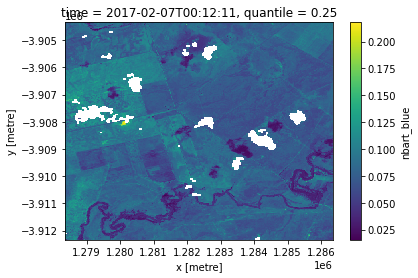

In [4]:
blue = ds.nbart_blue.astype(np.float32) / 1e4

# 1.- Filter reflectances greater than 0.5 
blue = blue.where(blue<.5)

# 2.- Filter reflectances with difference to lower quartile larger than 0.05 => (0.07)
blue = blue.where((blue - blue.quantile(0.25, dim='time'))<.07)

# 3.- Grow a 5x5 buffer around NaN pixels 
blue = buffer_nans(blue, 5)

# 4.- Discard frames with more than 25% missing pixels
blue = blue.isel(time=(blue.count(dim=('x','y'))/(400*400))>.25)

blue.isel(time=3).plot()

### Apply mask to all the other bands and save for PCA training

In [5]:
for band_name in ds:
    band = ds[band_name].astype(np.float32) / 1e4
    
    # 1. Apply blue mask
    band = band.sel(time=blue.time).where(~np.isnan(blue))

    # 2.- Interpolate NaNs over time linearly
    band = band.interpolate_na(dim='time')

    # 3.- Interpolate NaNs at the start and end using nearest neighbor
    band = band.interpolate_na(dim='time', method='nearest', fill_value='extrapolate')

    # 4.- Apply median rolling filter along time (window=3)
    band = band.rolling(time=3, min_periods=1).median()
    
    np.save(band_name, band)

## PCA decomposition

### Load libraries and create data stack

In [6]:
from sklearn.decomposition import PCA

stack = np.empty((0,400,400))

for fname in ["nbart_red.npy","nbart_green.npy","nbart_blue.npy",
              "nbart_nir_1.npy","nbart_nir_2.npy","nbart_swir_2.npy",
              "nbart_swir_3.npy"]:
    
    band = np.load(fname)
    stack = np.append(stack, band, axis=0)
    
stack = stack.reshape(stack.shape[0], -1)
    
stack.shape

(735, 160000)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 10, bias=False)  # 6*6 from image dimension
        self.fc2 = nn.Linear(1, 1000, bias=False)

    def forward(self, x):
        coeffs = self.fc1(x)
        base = self.fc2(x)
        return torch.mul(coeffs.view(10, 1), base.view(10, 100))


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=1, out_features=10, bias=False)
  (fc2): Linear(in_features=1, out_features=1000, bias=False)
)


In [25]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight
print(params[1].size())  # conv1's .weight

2
torch.Size([10, 1])
torch.Size([1000, 1])


In [28]:
input = torch.ones(1)
out = net(input)
print(out.size())

torch.Size([10, 100])


In [29]:
output = net(input)
target = torch.randn(1000)  # a dummy target, for example
target = target.view(10, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.1649, grad_fn=<MseLossBackward>)


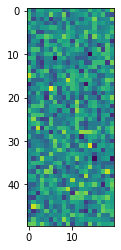

In [34]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)
target = torch.randn(1000)  # a dummy target, for example
target = target.view(10, -1)  # make it the same shape as output

plt.imshow(target.view(50,20))

0 tensor(9.0261e-07, grad_fn=<MseLossBackward>)
10000 tensor(7.0012e-07, grad_fn=<MseLossBackward>)
20000 tensor(6.0085e-07, grad_fn=<MseLossBackward>)
30000 tensor(5.6339e-07, grad_fn=<MseLossBackward>)
40000 tensor(5.4841e-07, grad_fn=<MseLossBackward>)
50000 tensor(5.4365e-07, grad_fn=<MseLossBackward>)
60000 tensor(5.4183e-07, grad_fn=<MseLossBackward>)
70000 tensor(5.4078e-07, grad_fn=<MseLossBackward>)
80000 tensor(5.4043e-07, grad_fn=<MseLossBackward>)
90000 tensor(5.4037e-07, grad_fn=<MseLossBackward>)
100000 tensor(5.4035e-07, grad_fn=<MseLossBackward>)
110000 tensor(5.4034e-07, grad_fn=<MseLossBackward>)
120000 tensor(5.4034e-07, grad_fn=<MseLossBackward>)
130000 tensor(5.4034e-07, grad_fn=<MseLossBackward>)
140000 tensor(5.4034e-07, grad_fn=<MseLossBackward>)
150000 tensor(5.4034e-07, grad_fn=<MseLossBackward>)
160000 tensor(5.4034e-07, grad_fn=<MseLossBackward>)
170000 tensor(5.4034e-07, grad_fn=<MseLossBackward>)
180000 tensor(5.4034e-07, grad_fn=<MseLossBackward>)
190000 

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

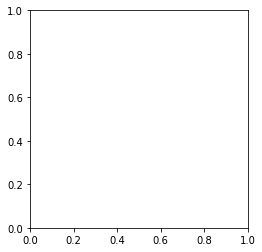

In [37]:
for i in range(200000):
    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()    # Does the update
    
    loss = criterion(output, target)
    if i % 10000 == 0:
        print(i, loss)
        


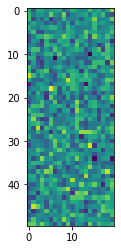

In [38]:
plt.imshow(net(input).detach().numpy().reshape(50,20))

In [41]:
params = list(net.parameters())

coeffs = params[0].detach().numpy()
base = params[1].detach().numpy().reshape((10,100))

coeffs.shape, base.shape

((10, 1), (10, 100))

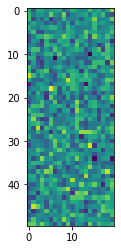

In [42]:
rec = coeffs*base

plt.imshow(rec.reshape(50,20))